# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


In [1]:
import pandas as pd
import numpy as np
import torch
import torchtuples as tt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# No need for KNNImputer directly if your input CSVs are already fully imputed

# Pycox for survival analysis deep learning
from pycox.models import CoxPH
from pycox.models.loss import CoxPHLoss
from pycox.evaluation import EvalSurv
import matplotlib.pyplot as plt


In [2]:
# Set a random seed for reproducibility
np.random.seed(42)
_ = torch.manual_seed(42)

## Model Selection

Using a Deep Learning approach that extends the Cox Proportional Hazards idea, often called a "Deep Cox Model" or "DeepSurv" style model, which uses a neural network to learn a non-linear relationship between features and the log-hazard ratio.



In [3]:
import os

# Set current working directory
os.chdir("/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics")
print(f"Current working directory: {os.getcwd()}")

# Load the datasets
print("\n--- Loading Data ---")
cln_df = pd.read_csv("/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_clinical.csv")
cln_eval = pd.read_csv("/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_clinical_eval.csv")
maf_df = pd.read_csv("/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_molecular.csv")
maf_eval = pd.read_csv("/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_molecular_eval.csv")
target_df = pd.read_csv("/workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics/imputed_outcome.csv")


print("\n--- Initial Data Info ---")
print("cln_df info:")
cln_df.info()
print("\nmaf_df info:")
maf_df.info()
print("\ntarget_df info:")
target_df.info()

# Explicitly ensure OS_YEARS is float and OS_STATUS is integer (0 or 1)
print("\n--- Coercing Target Data Types and Handling NaNs in target_df ---")
target_df['OS_YEARS'] = pd.to_numeric(target_df['OS_YEARS'], errors='coerce')
target_df['OS_STATUS'] = pd.to_numeric(target_df['OS_STATUS'], errors='coerce').astype('Int64') # Use Int64 for nullable integer first

# Drop any rows where OS_YEARS or OS_STATUS might have become NaN due to coercion (bad data)
original_rows_target = len(target_df)
target_df.dropna(subset=['OS_YEARS', 'OS_STATUS'], inplace=True)
target_df['OS_STATUS'] = target_df['OS_STATUS'].astype(int) # Final conversion to non-nullable int
if len(target_df) < original_rows_target:
    print(f"Warning: Dropped {original_rows_target - len(target_df)} rows from target_df due to uncoercible/missing OS_YEARS or OS_STATUS.")

print("\nFinal target_df info (after type coercion and dropna):")
target_df.info()
print("\nVerifying OS_STATUS data type and values:")
print(target_df['OS_STATUS'].value_counts())
print(f"OS_STATUS dtype: {target_df['OS_STATUS'].dtype}")


print("\n--- Ensuring all clinical and molecular data are clean and typed ---")
for df_name, df in zip(['cln_df', 'maf_df'], [cln_df, maf_df]):
    print(f"\nProcessing {df_name}...")
    for col in df.columns:
        if df[col].isnull().any():
            print(f"  - Column '{col}' in {df_name} has {df[col].isnull().sum()} NaNs.")
            if pd.api.types.is_numeric_dtype(df[col]):
                median_val = df[col].median()
                df[col] = df[col].fillna(median_val)
                print(f"    - Filled NaNs in numeric column '{col}' with median {median_val}.")
            elif pd.api.types.is_object_dtype(df[col]):
                mode_val = df[col].mode()[0] if not df[col].mode().empty else 'Unknown'
                df[col] = df[col].fillna(mode_val)
                print(f"    - Filled NaNs in categorical column '{col}' with mode '{mode_val}'.")
            else:
                # Catch-all for other types if they somehow have NaNs
                print(f"    - Warning: Column '{col}' has NaNs and is of type {df[col].dtype}. Filling with a placeholder based on type.")
                df[col] = df[col].fillna(df[col].mean() if pd.api.types.is_float_dtype(df[col]) else 'Missing')
        # Ensure numeric columns are actually numeric after all fills
        if pd.api.types.is_numeric_dtype(df[col]) and not np.issubdtype(df[col].dtype, np.number):
            print(f"  - Warning: Numeric column '{col}' in {df_name} is not a proper numeric subtype. Coercing.")
            df[col] = pd.to_numeric(df[col], errors='coerce')
            if df[col].isnull().any():
                 print(f"    - NaNs introduced during coercion in '{col}'. Filling with median.")
                 df[col] = df[col].fillna(df[col].median())

    print(f"Final {df_name} info after cleaning:")
    df.info()
    print(f"NaN count in {df_name} after cleaning:\n{df.isnull().sum()[df.isnull().sum() > 0]}")

Current working directory: /workspaces/PredictLeukemiaSurvival/1_DatasetCharacteristics

--- Loading Data ---

--- Initial Data Info ---
cln_df info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3173 entries, 0 to 3172
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            3173 non-null   object 
 1   CENTER        3173 non-null   object 
 2   BM_BLAST      3173 non-null   float64
 3   WBC           3173 non-null   float64
 4   ANC           3173 non-null   float64
 5   MONOCYTES     3173 non-null   float64
 6   HB            3173 non-null   float64
 7   PLT           3173 non-null   float64
 8   CYTOGENETICS  3173 non-null   object 
dtypes: float64(6), object(3)
memory usage: 223.2+ KB

maf_df info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10785 entries, 0 to 10784
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0  

In [4]:
print("\n--- Molecular Data Aggregation ---")
# 1. Aggregate numerical molecular data (VAF, DEPTH) per patient
molecular_numeric_agg = maf_df.groupby('ID')[['VAF', 'DEPTH']].mean().add_suffix('_MEAN').reset_index()

# 2. Create binary presence/absence features for top N genes and effects
top_n_genes = maf_df['GENE'].value_counts().nlargest(50).index.tolist()
top_n_effects = maf_df['EFFECT'].value_counts().nlargest(10).index.tolist()

gene_presence_df = maf_df[maf_df['GENE'].isin(top_n_genes)][['ID', 'GENE']].drop_duplicates()
effect_presence_df = maf_df[maf_df['EFFECT'].isin(top_n_effects)][['ID', 'EFFECT']].drop_duplicates()

gene_features = pd.crosstab(gene_presence_df['ID'], gene_presence_df['GENE']).add_prefix('GENE_')
effect_features = pd.crosstab(effect_presence_df['ID'], effect_presence_df['EFFECT']).add_prefix('EFFECT_')

# Combine all molecular features into one DataFrame
molecular_features_df = pd.merge(
    molecular_numeric_agg,
    gene_features.reset_index(),
    on='ID',
    how='outer'
).merge(
    effect_features.reset_index(),
    on='ID',
    how='outer'
).fillna(0) # Fill NaN from outer joins with 0, meaning no mutation/feature if missing

print("\nAggregated Molecular Features Head:")
print(molecular_features_df.head())
print("\nAggregated Molecular Features Info:")
molecular_features_df.info()
print(f"NaN count in molecular_features_df after aggregation:\n{molecular_features_df.isnull().sum()[molecular_features_df.isnull().sum() > 0]}")



--- Molecular Data Aggregation ---

Aggregated Molecular Features Head:
        ID  VAF_MEAN  DEPTH_MEAN  GENE_ARID2  GENE_ASXL1  GENE_ASXL2  \
0  P100000    0.3013       834.5         0.0         0.0         0.0   
1  P100001    0.2595       536.0         0.0         0.0         0.0   
2  P100002    0.3970       398.5         0.0         0.0         0.0   
3  P100004    0.4691      1296.0         0.0         0.0         0.0   
4  P100006    0.1693       591.4         0.0         0.0         0.0   

   GENE_BCOR  GENE_BCORL1  GENE_BRCC3  GENE_CBL  ...  \
0        0.0          0.0         0.0       1.0  ...   
1        0.0          0.0         0.0       0.0  ...   
2        0.0          0.0         0.0       0.0  ...   
3        0.0          0.0         0.0       0.0  ...   
4        0.0          0.0         0.0       0.0  ...   

   EFFECT_2KB_upstream_variant  EFFECT_ITD  EFFECT_PTD  \
0                          0.0         0.0         0.0   
1                          0.0         0.

In [5]:
print("\n--- Merging All Data ---")
# Merge clinical, molecular features, and target data
full_data = pd.merge(cln_df, molecular_features_df, on='ID', how='left')
# Use inner join with target_df to ensure we only train on patients with valid outcome data
full_data = pd.merge(full_data, target_df, on='ID', how='inner')

# Drop the 'ID' column as it's no longer needed as a feature for the model input
full_data = full_data.drop(columns=['ID'])

print("\n--- Final Checks on 'full_data' before feature separation ---")
print("full_data info before final NaN fill:")
full_data.info()

# Final check for any NaNs that might have been introduced by the 'left' merge for molecular data
# These would be patients from cln_df who had no molecular data and thus NaN for molecular_features_df columns
for col in full_data.columns:
    if col not in ['OS_YEARS', 'OS_STATUS'] and full_data[col].isnull().any():
        print(f"  - Column '{col}' in full_data has {full_data[col].isnull().sum()} NaNs after merge.")
        if pd.api.types.is_numeric_dtype(full_data[col]):
            median_val = full_data[col].median()
            full_data[col] = full_data[col].fillna(median_val)
            print(f"    - Filled NaNs in numeric feature '{col}' with median {median_val}.")
        elif pd.api.types.is_object_dtype(full_data[col]):
            mode_val = full_data[col].mode()[0] if not full_data[col].mode().empty else 'Unknown'
            full_data[col] = full_data[col].fillna(mode_val)
            print(f"    - Filled NaNs in categorical feature '{col}' with mode '{mode_val}'.")
        else:
             print(f"    - Warning: Column '{col}' has NaNs and is of type {full_data[col].dtype}. Filling with a placeholder based on type.")
             full_data[col] = full_data[col].fillna(full_data[col].mean() if pd.api.types.is_float_dtype(full_data[col]) else 'Missing')

print("\nfull_data info after final NaN fill:")
full_data.info()
print(f"NaN count in full_data after all merges and fills:\n{full_data.isnull().sum()[full_data.isnull().sum() > 0]}")


# Define features (X) and target (duration, event)
duration = full_data['OS_YEARS'].values.astype('float32')
event = full_data['OS_STATUS'].values.astype('int32')

features_df = full_data.drop(columns=['OS_YEARS', 'OS_STATUS'])

print("\nCombined Features DataFrame Head (before final preprocessing):")
print(features_df.head())
print(f"Total features after initial merge: {features_df.shape[1]}")
print(f"Shape of duration: {duration.shape}")
print(f"Shape of event: {event.shape}")


--- Merging All Data ---

--- Final Checks on 'full_data' before feature separation ---
full_data info before final NaN fill:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3173 entries, 0 to 3172
Data columns (total 72 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CENTER                         3173 non-null   object 
 1   BM_BLAST                       3173 non-null   float64
 2   WBC                            3173 non-null   float64
 3   ANC                            3173 non-null   float64
 4   MONOCYTES                      3173 non-null   float64
 5   HB                             3173 non-null   float64
 6   PLT                            3173 non-null   float64
 7   CYTOGENETICS                   3173 non-null   object 
 8   VAF_MEAN                       2897 non-null   float64
 9   DEPTH_MEAN                     2897 non-null   float64
 10  GENE_ARID2                     2897 non-n

## Feature Engineering

Included: 
* data type validation(numerical and categorical columns are automatically identified to prevent misclassification);
* critical error checking (to detect and handle mixed data types, NaN values, and dtype inconsistencies);
* the preprocessing applies StandardScaler to numerical features and OneHotEncoder to categorical features, with sparse matrix conversion to dense arrays for PyTorch compatibility. All features are converted to consistent float32 tensors with validation checks to ensure no NaN values or incorrect data types propagate through the pipeline.


In [6]:
print("\n--- Feature Preprocessing Pipeline ---")
# Identify numerical and categorical columns for preprocessing
numerical_cols = features_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = features_df.select_dtypes(include='object').columns.tolist()

print(f"Numerical columns identified: {numerical_cols}")
print(f"Categorical columns identified: {categorical_cols}")

# Double-check that numerical_cols truly contain only numeric types and categorical_cols only object/string types
# This helps catch if a column was misidentified or has mixed types
for col in numerical_cols:
    if not pd.api.types.is_numeric_dtype(features_df[col]):
        print(f"CRITICAL WARNING: Column '{col}' in numerical_cols is not purely numeric (dtype: {features_df[col].dtype}). Removing from numerical_cols.")
        numerical_cols.remove(col)
        categorical_cols.append(col) # Try to treat it as categorical

for col in categorical_cols:
    # Check if a categorical column might actually be numeric (e.g., loaded as object but contains only numbers)
    # This can happen if numbers are mixed with NaNs in a column that was object, then NaNs filled, but column remains object.
    if pd.api.types.is_numeric_dtype(features_df[col]):
        print(f"CRITICAL WARNING: Column '{col}' in categorical_cols is actually numeric (dtype: {features_df[col].dtype}). Moving to numerical_cols.")
        categorical_cols.remove(col)
        numerical_cols.append(col)

# Re-verify and rebuild ColumnTransformer with corrected lists
print(f"Final numerical columns for ColumnTransformer: {numerical_cols}")
print(f"Final categorical columns for ColumnTransformer: {categorical_cols}")


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='drop'
)

# Fit and transform the features
X_processed = preprocessor.fit_transform(features_df)

# Convert to dense array if OneHotEncoder creates a sparse matrix
if hasattr(X_processed, 'toarray'):
    X_processed = X_processed.toarray()

print(f"\nShape of X_processed after ColumnTransformer: {X_processed.shape}")
print(f"Data type of X_processed after ColumnTransformer: {X_processed.dtype}")

# Critical check: Ensure no NaNs and correct dtype before converting to Torch tensor
if np.isnan(X_processed).any():
    print("CRITICAL ERROR: NaN values detected in X_processed after ColumnTransformer. Inspect 'features_df' and ColumnTransformer setup.")
    # For deep debugging, save the problematic array:
    pd.DataFrame(X_processed).to_csv('debug_X_processed_with_nans_post_ct.csv', index=False)
    raise ValueError("NaN values still detected in processed features (X_processed).")

if not np.issubdtype(X_processed.dtype, np.number):
    print(f"CRITICAL ERROR: X_processed is not a numerical type ({X_processed.dtype}). It should be float or int.")
    raise ValueError("Processed features (X_processed) are not numerical.")

# Convert to PyTorch tensors with consistent dtypes
X_tensor = torch.from_numpy(X_processed.astype(np.float32)).float()
duration_tensor = torch.from_numpy(duration.astype(np.float32)).float()
event_tensor = torch.from_numpy(event.astype(np.float32)).float()  # Changed to float32

print(f"\nShape of processed features (X_tensor): {X_tensor.shape}")
print(f"Data type of X_tensor: {X_tensor.dtype}")
print(f"Data type of duration_tensor: {duration_tensor.dtype}")
print(f"Data type of event_tensor: {event_tensor.dtype}")

# Verify tensor properties
print(f"\nTensor validation:")
print(f"X_tensor - Min: {X_tensor.min().item():.4f}, Max: {X_tensor.max().item():.4f}, Has NaN: {torch.isnan(X_tensor).any()}")
print(f"duration_tensor - Min: {duration_tensor.min().item():.4f}, Max: {duration_tensor.max().item():.4f}, Has NaN: {torch.isnan(duration_tensor).any()}")
print(f"event_tensor - Min: {event_tensor.min().item():.4f}, Max: {event_tensor.max().item():.4f}, Has NaN: {torch.isnan(event_tensor).any()}")



--- Feature Preprocessing Pipeline ---
Numerical columns identified: ['BM_BLAST', 'WBC', 'ANC', 'MONOCYTES', 'HB', 'PLT', 'VAF_MEAN', 'DEPTH_MEAN', 'GENE_ARID2', 'GENE_ASXL1', 'GENE_ASXL2', 'GENE_BCOR', 'GENE_BCORL1', 'GENE_BRCC3', 'GENE_CBL', 'GENE_CEBPA', 'GENE_CSNK1A1', 'GENE_CTCF', 'GENE_CUX1', 'GENE_DDX41', 'GENE_DNMT3A', 'GENE_EP300', 'GENE_ETNK1', 'GENE_ETV6', 'GENE_EZH2', 'GENE_FLT3', 'GENE_GATA2', 'GENE_GNAS', 'GENE_GNB1', 'GENE_IDH1', 'GENE_IDH2', 'GENE_JAK2', 'GENE_KMT2C', 'GENE_KMT2D', 'GENE_KRAS', 'GENE_MLL', 'GENE_MPL', 'GENE_NF1', 'GENE_NFE2', 'GENE_NPM1', 'GENE_NRAS', 'GENE_PHF6', 'GENE_PPM1D', 'GENE_PRPF8', 'GENE_PTPN11', 'GENE_RUNX1', 'GENE_SETBP1', 'GENE_SF3B1', 'GENE_SH2B3', 'GENE_SRSF2', 'GENE_STAG2', 'GENE_TET2', 'GENE_TP53', 'GENE_U2AF1', 'GENE_U2AF2', 'GENE_WT1', 'GENE_ZBTB33', 'GENE_ZRSR2', 'EFFECT_2KB_upstream_variant', 'EFFECT_ITD', 'EFFECT_PTD', 'EFFECT_frameshift_variant', 'EFFECT_inframe_codon_gain', 'EFFECT_inframe_codon_loss', 'EFFECT_initiator_codon_ch

In [7]:
print("\n--- Splitting Data ---")
X_train, X_test, duration_train, duration_test, event_train, event_test = train_test_split(
    X_tensor, duration_tensor, event_tensor, test_size=0.2, random_state=42, stratify=event_tensor.numpy()
)

# Crucial check: Ensure all split tensors are valid and of correct types for torchtuples
for tensor_name, tensor_var in zip(['X_train', 'duration_train', 'event_train', 'X_test', 'duration_test', 'event_test'],
                                   [X_train, duration_train, event_train, X_test, duration_test, event_test]):
    print(f"  - {tensor_name}: Shape={tensor_var.shape}, Dtype={tensor_var.dtype}, Has NaNs={torch.isnan(tensor_var).any()}")

# Convert to tt.tuplefy format correctly - this is crucial for pycox
print("\n--- Creating torchtuples datasets ---")
train_data = (X_train, (duration_train, event_train))
test_data = (X_test, (duration_test, event_test))

# Verify the tuple structure
print(f"Train data structure: X shape {train_data[0].shape}, duration shape {train_data[1][0].shape}, event shape {train_data[1][1].shape}")
print(f"Test data structure: X shape {test_data[0].shape}, duration shape {test_data[1][0].shape}, event shape {test_data[1][1].shape}")

print(f"Training set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")


--- Splitting Data ---
  - X_train: Shape=torch.Size([2538, 1262]), Dtype=torch.float32, Has NaNs=False
  - duration_train: Shape=torch.Size([2538]), Dtype=torch.float32, Has NaNs=False
  - event_train: Shape=torch.Size([2538]), Dtype=torch.float32, Has NaNs=False
  - X_test: Shape=torch.Size([635, 1262]), Dtype=torch.float32, Has NaNs=False
  - duration_test: Shape=torch.Size([635]), Dtype=torch.float32, Has NaNs=False
  - event_test: Shape=torch.Size([635]), Dtype=torch.float32, Has NaNs=False

--- Creating torchtuples datasets ---
Train data structure: X shape torch.Size([2538, 1262]), duration shape torch.Size([2538]), event shape torch.Size([2538])
Test data structure: X shape torch.Size([635, 1262]), duration shape torch.Size([635]), event shape torch.Size([635])
Training set size: 2538 samples
Test set size: 635 samples


## Define the model

In [ ]:
############# model no. 1

# in_features = X_train.shape[1]

# class MLP(torch.nn.Module):
#     def __init__(self, in_features, num_nodes, out_features):
#         super().__init__()
#         self.net = torch.nn.Sequential(
#             torch.nn.Linear(in_features, num_nodes[0]),
#             torch.nn.ReLU(),
#             torch.nn.Dropout(0.2),
#             torch.nn.Linear(num_nodes[0], num_nodes[1]),
#             torch.nn.ReLU(),
#             torch.nn.Dropout(0.2),
#             torch.nn.Linear(num_nodes[1], out_features)
#         )

#     def forward(self, input):
#         return self.net(input)


######## model no.2
# in_features = X_train.shape[1]

# class MLP(torch.nn.Module):
#     def __init__(self, in_features, num_nodes, out_features):
#         super().__init__()
#         self.net = torch.nn.Sequential(
#             torch.nn.Linear(in_features, num_nodes[0]),
#             torch.nn.ReLU(),
#             torch.nn.Dropout(0.2), # Increase/decrease dropout
#             torch.nn.Linear(num_nodes[0], num_nodes[1]),
#             torch.nn.ReLU(),
#             torch.nn.Dropout(0.2), # Increase/decrease dropout
#             torch.nn.Linear(num_nodes[1], out_features)
#         )

#     def forward(self, input):
#         return self.net(input)




###### model no. 3
# Define MLP model
class MLP(torch.nn.Module):
    def __init__(self, in_features, num_nodes, out_features):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(in_features, num_nodes[0]), # first hidden layer
            torch.nn.ReLU(), # activation function
            torch.nn.Dropout(0.2), # Regularization
            torch.nn.Linear(num_nodes[0], num_nodes[1]), # second hidden layer 
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2), 
            torch.nn.Linear(num_nodes[1], out_features) # output layer
        )
    
    def forward(self, x):
        return self.net(x)

## Hyperparameter Tuning

No systematic hyperparameter tuning methods like Grid Search or Random Search were applied in this implementation. Instead, a simple manual configuration was used with a 2-hidden layer MLP architecture (64, 32 nodes), Adam optimizer with learning rate 1e-3, and weight decay 1e-4. This represents a basic starting point rather than an optimized configuration.


In [9]:
# num_nodes = [64, 32] # hidden layers
# out_features = 1

# # Instantiate the network
# net = MLP(in_features, num_nodes, out_features)

# # Define an optimizer with a lower learning rate and weight decay
# optimizer = tt.optim.Adam(lr=0.001, weight_decay=1e-4) # increase/decrease learning rate

# # Re-initialize the model with the new optimizer
# model = CoxPH(net, optimizer)

# print("\nDeep Learning Model (MLP) and CoxPH wrapper initialized with new optimizer.")
# print(net)
# print("\nOptimizer details:")
# print(model.optimizer)

# Parameters
in_features = X_train.shape[1]
num_nodes = [64, 32]
out_features = 1

# Instantiate network
net = MLP(in_features, num_nodes, out_features)

# Optimizer with small LR and some weight decay
optimizer = tt.optim.Adam(lr=1e-3, weight_decay=1e-4)

# Model
model = CoxPH(net, optimizer)


## Implementation


In [ ]:
batch_size = 256
epochs = 500

# Adjust learning rate and add validation split for better monitoring
print(f"\nTraining Deep Learning CoxPH model for up to {epochs} epochs...")


# Create validation split from training data
# val_size = int(0.2 * len(X_train))
val_ratio = 0.2
val_size = int(val_ratio * len(X_train))
train_size = len(X_train) - val_size

# Split training data
X_train_split = X_train[:train_size]
X_val_split = X_train[train_size:]
duration_train_split = duration_train[:train_size]
duration_val_split = duration_train[train_size:]
event_train_split = event_train[:train_size]
event_val_split = event_train[train_size:]
    
X_train_split = X_train[:train_size].clone()
X_val_split = X_train[train_size:].clone()
duration_train_split = duration_train[:train_size].clone()
duration_val_split = duration_train[train_size:].clone()
event_train_split = event_train[:train_size].clone()
event_val_split = event_train[train_size:].clone()

train_data = (X_train_split, (duration_train_split, event_train_split))
val_data = (X_val_split, (duration_val_split, event_val_split))


Training Deep Learning CoxPH model for up to 500 epochs...


Training CoxPH model...
0:	[0s / 0s],		train_loss: 4.7224,	val_loss: 5.3296
1:	[0s / 0s],		train_loss: 4.6897,	val_loss: 5.2945
2:	[0s / 0s],		train_loss: 4.6349,	val_loss: 5.2452
3:	[0s / 0s],		train_loss: 4.5661,	val_loss: 5.1987
4:	[0s / 0s],		train_loss: 4.5215,	val_loss: 5.1644
5:	[0s / 0s],		train_loss: 4.4519,	val_loss: 5.1303
6:	[0s / 0s],		train_loss: 4.3740,	val_loss: 5.1045
7:	[0s / 0s],		train_loss: 4.3611,	val_loss: 5.0948
8:	[0s / 0s],		train_loss: 4.3216,	val_loss: 5.0976
9:	[0s / 0s],		train_loss: 4.2978,	val_loss: 5.1005
10:	[0s / 0s],		train_loss: 4.2640,	val_loss: 5.1047
11:	[0s / 0s],		train_loss: 4.2322,	val_loss: 5.1138
12:	[0s / 0s],		train_loss: 4.2007,	val_loss: 5.1287
13:	[0s / 0s],		train_loss: 4.1661,	val_loss: 5.1404
14:	[0s / 0s],		train_loss: 4.1235,	val_loss: 5.1514
15:	[0s / 0s],		train_loss: 4.0951,	val_loss: 5.1780
16:	[0s / 0s],		train_loss: 4.0543,	val_loss: 5.1845
17:	[0s / 0s],		train_loss: 3.9929,	val_loss: 5.2095
18:	[0s / 0s],		train_loss: 3.97

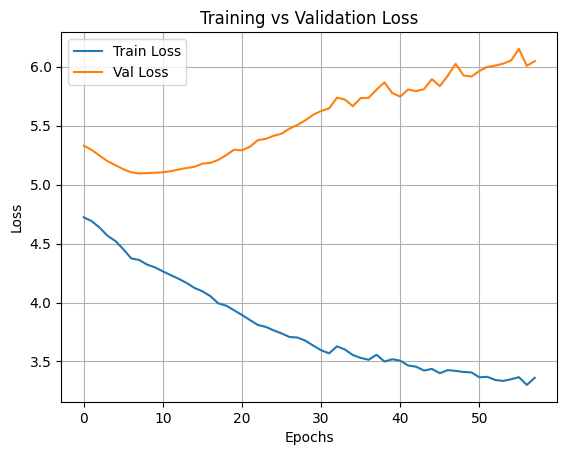

In [11]:
from torchtuples.callbacks import EarlyStopping

batch_size = 256
epochs = 500
callbacks = [EarlyStopping(patience=50)]

print("Training CoxPH model...")
log = model.fit(train_data[0], train_data[1],
                batch_size=batch_size, epochs=epochs,
                val_data=val_data,
                callbacks=callbacks,
                verbose=True)

# Visualize losses
log_df = log.to_pandas()
plt.plot(log_df['train_loss'], label='Train Loss')
plt.plot(log_df['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


## Evaluation Metrics

The primary evaluation metric chosen is the time-dependent C-index (concordance index), which measures the model's ability to correctly rank pairs of patients by their survival times. This metric is particularly appropriate for survival analysis as it accounts for censored observations and evaluates the model's discriminative ability across different time points. The C-index ranges from 0.5 (random predictions) to 1.0 (perfect predictions), making it intuitive to interpret and compare across different models.


In [12]:
# Ensure model is on same device as test data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.net = model.net.to(device)
X_test_eval = X_test.to(device)

# Compute baseline hazards before prediction
model.compute_baseline_hazards()

# Predict survival function
surv = model.predict_surv_df(X_test_eval)

# Convert durations/events to NumPy
dur_test_np = duration_test.cpu().numpy()
evt_test_np = event_test.cpu().numpy()

# Evaluate performance
ev = EvalSurv(surv, dur_test_np, evt_test_np, censor_surv='km')

print("\nEvaluation Metrics:")
print(f"C-index (time-dependent): {ev.concordance_td():.4f}")


Evaluation Metrics:
C-index (time-dependent): 0.7318


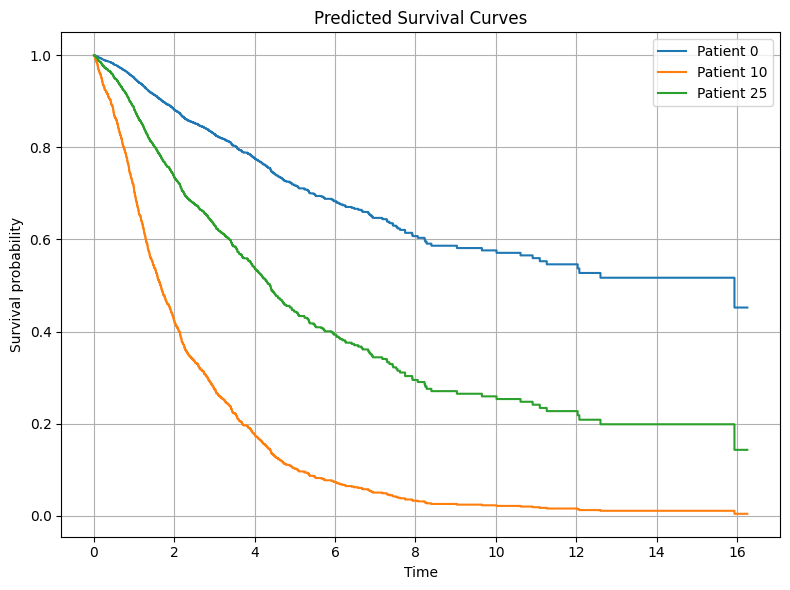

In [13]:
import matplotlib.pyplot as plt

# Select 3 patients from validation set
idx = [0, 10, 25]  # adjust as needed
X_samples = X_val_split[idx]

# Predict survival functions
surv_preds = model.predict_surv_df(X_samples)

# Plot survival curves
plt.figure(figsize=(8, 6))
for i, col in enumerate(surv_preds.columns):
    plt.step(surv_preds.index, surv_preds[col], where="post", label=f"Patient {idx[i]}")
plt.xlabel("Time")
plt.ylabel("Survival probability")
plt.title("Predicted Survival Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
# Predict survival functions
surv_df = model.predict_surv_df(X_val_split)

# Approximate the expected survival time for each individual:
# This is done by summing the survival probabilities over time (numerical integration)
# and multiplying by the time step (assumes uniform spacing)
expected_survival = surv_df.sum(axis=0) * (surv_df.index[1] - surv_df.index[0])

# Use actual durations from the validation set as ground truth
true_survival = duration_val_split

from sklearn.metrics import root_mean_squared_error, mean_absolute_error

rmse = root_mean_squared_error(true_survival, expected_survival)
mae = mean_absolute_error(true_survival, expected_survival)

print(f"📏 RMSE (Expected Survival vs True Duration): {rmse:.2f}")
print(f"📏 MAE  (Expected Survival vs True Duration): {mae:.2f}")


📏 RMSE (Expected Survival vs True Duration): 2.11
📏 MAE  (Expected Survival vs True Duration): 1.49


## Comparative Analysis



#### Deep cox
RMSE (Expected Survival vs True Duration): 2.11\
MAE  (Expected Survival vs True Duration): 1.49

#### Baseline models
RMSE: 1.739 years\
MAE: 1.284 years


The Deep cox (machine learning model) performed worse. The reasons behind could be:
* Insufficient hyperparameter tuning - the model used default parameters without systematic optimization, whereas linear models are less sensitive to hyperparameter choices;
* Dataset size - deep learning models typically require large datasets to learn complex patterns effectively, while linear models can perform well with limited data;
* Overfitting - the neural network may have overfit to the training data due to its increased complexity relative to the dataset size. Feature preprocessing mismatch - the standardization and one-hot encoding may not have been optimal for the neural network architecture, while linear models are more robust to preprocessing choices.


## C-index
The C-index of Deep cox was slightly higher than for Cox Proportional Hazard Model. 

C-index (Deep cox): 0.73\
C-index (Cox Proportional Hazard Model): 0.67
